### Milestone 3: Traditional statistical and machine learning methods, due Wednesday, April 19, 2017

Think about how you would address the genre prediction problem with traditional statistical or machine learning methods. This includes everything you learned about modeling in this course before the deep learning part. Implement your ideas and compare different classifiers. Report your results and discuss what challenges you faced and how you overcame them. What works and what does not? If there are parts that do not work as expected, make sure to discuss briefly what you think is the cause and how you would address this if you would have more time and resources. 

You do not necessarily need to use the movie posters for this step, but even without a background in computer vision, there are very simple features you can extract from the posters to help guide a traditional machine learning model. Think about the PCA lecture for example, or how to use clustering to extract color information. In addition to considering the movie posters it would be worthwhile to have a look at the metadata that IMDb provides. 

You could use Spark and the [ML library](https://spark.apache.org/docs/latest/ml-features.html#word2vec) to build your model features from the data. This may be especially beneficial if you use additional data, e.g., in text form.

You also need to think about how you are going to evaluate your classifier. Which metrics or scores will you report to show how good the performance is?

The notebook to submit this week should at least include:

- Detailed description and implementation of two different models
- Description of your performance metrics
- Careful performance evaluations for both models
- Visualizations of the metrics for performance evaluation
- Discussion of the differences between the models, their strengths, weaknesses, etc. 
- Discussion of the performances you achieved, and how you might be able to improve them in the future

#### Preliminary Peer Assessment

It is important to provide positive feedback to people who truly worked hard for the good of the team and to also make suggestions to those you perceived not to be working as effectively on team tasks. We ask you to provide an honest assessment of the contributions of the members of your team, including yourself. The feedback you provide should reflect your judgment of each team member’s:

- Preparation – were they prepared during team meetings?
- Contribution – did they contribute productively to the team discussion and work?
- Respect for others’ ideas – did they encourage others to contribute their ideas?
- Flexibility – were they flexible when disagreements occurred?

Your teammate’s assessment of your contributions and the accuracy of your self-assessment will be considered as part of your overall project score.

Preliminary Peer Assessment: [https://goo.gl/forms/WOYC7pwRCSU0yV3l1](https://goo.gl/forms/WOYC7pwRCSU0yV3l1)

In [1]:
import json
import urllib
import cStringIO
from PIL import Image
from imdb import IMDb
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import time
import ast
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
import difflib

/Users/Xincheng/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# part 3 - top 10 most popular movies of 2016 from TMDb and their genre
top_2016_1 = urllib.urlopen("https://api.themoviedb.org/3/discover/movie?api_key=2dc6c9f1d17bd39dcbaef83321e1b5a3&sort_by=popularity.desc&include_adult=false&include_video=false&page=1&primary_release_year=2016")
top_2016_1_json = json.loads(top_2016_1.read())

# get genre list
genre_list = urllib.urlopen("https://api.themoviedb.org/3/genre/movie/list?api_key=2dc6c9f1d17bd39dcbaef83321e1b5a3&language=en-US")

genre_list_json = json.loads(genre_list.read()) 

genre_lst = {}
for i in genre_list_json['genres']:
    genre_lst[i['id']] = str(i['name'])
    
# top most popular movies of 2016
top_2016_1 = urllib.urlopen("https://api.themoviedb.org/3/discover/movie?api_key=2dc6c9f1d17bd39dcbaef83321e1b5a3&sort_by=popularity.desc&include_adult=false&include_video=false&page=1&primary_release_year=2016")
top_2016_1_json = json.loads(top_2016_1.read())


for i in top_2016_1_json['results']:
    print i['title'], [genre_lst[j] for j in i['genre_ids']]


Sing ['Animation', 'Comedy', 'Drama', 'Family', 'Music']
Split ['Horror', 'Thriller']
Fantastic Beasts and Where to Find Them ['Adventure', 'Action', 'Fantasy']
Rogue One: A Star Wars Story ['Action', 'Drama', 'Science Fiction', 'War']
Arrival ['Thriller', 'Drama', 'Science Fiction', 'Mystery']
Deadpool ['Action', 'Adventure', 'Comedy', 'Romance']
Finding Dory ['Adventure', 'Animation', 'Comedy', 'Family']
Boyka: Undisputed IV ['Action']
La La Land ['Comedy', 'Drama', 'Music', 'Romance']
Doctor Strange ['Action', 'Adventure', 'Fantasy', 'Science Fiction']
Tomorrow Everything Starts ['Drama', 'Comedy']
Captain America: Civil War ['Adventure', 'Action', 'Science Fiction']
Lion ['Drama']
The Great Wall ['Action', 'Adventure', 'Fantasy']
X-Men: Apocalypse ['Action', 'Adventure', 'Fantasy', 'Science Fiction']
Hidden Figures ['History', 'Drama']
Hacksaw Ridge ['Drama', 'History', 'War']
Underworld: Blood Wars ['Action', 'Horror']
Batman v Superman: Dawn of Justice ['Action', 'Adventure', 'Fa

In [3]:
import ast

movie_2000_df = pd.read_csv('tmdb_metadata.csv')
movie_2000_df = movie_2000_df.drop('Unnamed: 0', axis=1)

movie_2000_df = movie_2000_df.dropna()

labels = []
for i in movie_2000_df.genre_ids:
    label_matrix = np.zeros(len(genre_lst.keys()), dtype=int)
    for j in ast.literal_eval(i):
        if j in genre_lst.keys():
            label_matrix[genre_lst.keys().index(j)] = 1
    labels.append(label_matrix)
movie_2000_df['labels'] = labels

# convert dates
import datetime
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

int_dates =[]

for i in movie_2000_df.release_date:
    f = i.split('-')
    a = datetime.date(int(f[0]), int(f[1]), int(f[2]))
    int_dates.append(to_integer(a))

movie_2000_df['int_dates'] = int_dates

In [4]:
data = movie_2000_df.drop(['genre_ids', 'movie_id', 'poster_path', 'overview', 'title', 'release_date'], axis = 1)

In [5]:
words = pd.read_csv('genre_words_pca.csv').drop('Unnamed: 0', axis = 1)

In [6]:
x = pd.concat([data[['popularity', 'vote_average', 'vote_count', 'int_dates']], words], axis = 1)
y = data['labels']
y = np.asarray(y.tolist())
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [7]:
# metric 2 - match ratio 
def compute_match_ratio(y_true, y_pred):
    # prediction accuracies according to similarity ratio 
    test_similarity = []
    for i in range(0,len(y_true)):
        sm = difflib.SequenceMatcher(None, a = y_true[i], b = y_pred[i])
        # ratio() returns a measure of the sequences’ similarity as a float in the range [0, 1].
        # Where T is the total number of elements in both sequences, and M is the number of matches, 
        # this is 2.0*M / T. 1.0 if the sequences are identical, and 0.0 if they have nothing in common.
        test_similarity.append(sm.ratio())
        
    # the histogram of the data (optional)
    n, bins, patches = plt.hist(test_similarity, facecolor='green', alpha=0.75)
    plt.xlabel('Accuracies')
    plt.ylabel('Frequencies')
    plt.axvline(x = np.mean(test_similarity))
    plt.grid(True)
    plt.show()

    # metric 2: mean and median test similarity
    return np.mean(test_similarity), np.median(test_similarity);

## SVM

In [8]:
# Parameters for tuning
C = np.power(10., range(-3, 4))
gammas = np.power(10., range(-3, 4))

# To keep track of the best model
best_score = 0

# Run grid search for model with 5-fold cross validation
print '5-fold cross validation:'


for c in C:
    for gamma in gammas:
        # Cross validation for every experiment
        k_folds = KFold(x_train.shape[0], n_folds=5, shuffle=True)
        scores = []
        for train_indices, validation_indices in k_folds:
            # Generate training data
            x_train_cv = x_train.values[train_indices]
            y_train_cv = y_train[train_indices]
            # Generate validation data
            x_validate = x_train.values[validation_indices]
            y_validate = y_train[validation_indices]
            
            # Fit random forest on training data
            model = OneVsRestClassifier(SVC(kernel = 'rbf', C = c, gamma = gamma))
            model.fit(x_train_cv, y_train_cv)
            # Score on validation data
            scores += [model.score(x_validate, y_validate)]
        # Record and report accuracy
        average_score = np.mean(scores)
        print "c:", c, "gamma:", gamma, "Score:", average_score
        
        # Update our record of the best parameters see so far
        if average_score > best_score:
            best_score = average_score
            best_c = c
            best_gamma = gamma

# Fit model on entire train set using chosen C
ovr_svc_rbf = OneVsRestClassifier(SVC(kernel = 'rbf', C = best_c, gamma = best_gamma))
ovr_svc_rbf.fit(x_train, y_train)
ovr_svc_rbf_score = ovr_svc_rbf.score(x_test, y_test)
ovr_svc_rbf_predicted = ovr_svc_rbf.predict(x_test)
ovr_svc_rbf_match = compute_match_ratio(y_test, ovr_svc_rbf_predicted)

print 'Chosen c:', best_c
print 'Chosen gamma:', best_gamma
print 'Test accuracy:', ovr_svc_rbf_score
print 'Match ratio: ', ovr_svc_rbf_match

5-fold cross validation:
c: 0.001 gamma: 0.001 Score: 0.0204047682704
c: 0.001 gamma: 0.01 Score: 0.0204026463985
c: 0.001 gamma: 0.1 Score: 0.0204034951473
c: 0.001 gamma: 1.0 Score: 0.0204013732754
c: 0.001 gamma: 10.0 Score: 0.0204026463985
c: 0.001 gamma: 100.0 Score: 0.0204017976498
c: 0.001 gamma: 1000.0 Score: 0.0204030707729
c: 0.01 gamma: 0.001 Score: 0.0204022220242
c: 0.01 gamma: 0.01 Score: 0.0204026463985
c: 0.01 gamma: 0.1 Score: 0.0204051926447
c: 0.01 gamma: 1.0 Score: 0.0204005245267
c: 0.01 gamma: 10.0 Score: 0.0204013732754
c: 0.01 gamma: 100.0 Score: 0.0204047682704
c: 0.01 gamma: 1000.0 Score: 0.0204022220242
c: 0.1 gamma: 0.001 Score: 0.0204022220242
c: 0.1 gamma: 0.01 Score: 0.0204026463985
c: 0.1 gamma: 0.1 Score: 0.0204022220242
c: 0.1 gamma: 1.0 Score: 0.0204030707729
c: 0.1 gamma: 10.0 Score: 0.0204013732754
c: 0.1 gamma: 100.0 Score: 0.0204013732754
c: 0.1 gamma: 1000.0 Score: 0.0204034951473
c: 1.0 gamma: 0.001 Score: 0.0381796885941
c: 1.0 gamma: 0.01 Scor

NameError: global name 'difflib' is not defined

**Please ignore this error message. We did not have enough time to rerun this portion to get rid of the error (took about 6 hours to run this block), so we are keeping this in the notebook. This error has nothing to do with the cross-validation. Based on the results of the cross validation, the best gamma is 0.001 and the best C is 1.0. **

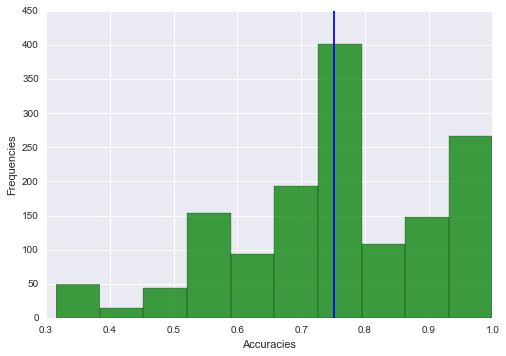

In [8]:
best_c = 1.0
best_gamma = 0.001
ovr_svc_rbf = OneVsRestClassifier(SVC(kernel = 'rbf', C = best_c, gamma = best_gamma))
ovr_svc_rbf.fit(x_train, y_train)
ovr_svc_rbf_score = ovr_svc_rbf.score(x_test, y_test)
ovr_svc_rbf_predicted = ovr_svc_rbf.predict(x_test)
ovr_svc_rbf_match = compute_match_ratio(y_test, ovr_svc_rbf_predicted)

In [9]:
print 'Chosen c:', best_c
print 'Chosen gamma:', best_gamma
print 'Test accuracy:', ovr_svc_rbf_score
print 'Match ratio: ', ovr_svc_rbf_match

Chosen c: 1.0
Chosen gamma: 0.001
Test accuracy: 0.0414683888511
Match ratio:  (0.75186947654656699, 0.78947368421052633)


In [ ]:
# # Parameters for tuning
# C = np.power(10., range(-1, 2))
# polys = range(2, 5)

# # To keep track of the best model
# best_score = 0

# # Run grid search for model with 5-fold cross validation
# print '5-fold cross validation:'


# for c in C:
#     for poly in polys:
#         # Cross validation for every experiment
#         k_folds = KFold(x_train.shape[0], n_folds=5, shuffle=True)
#         scores = []
#         for train_indices, validation_indices in k_folds:
#             # Generate training data
#             x_train_cv = x_train.values[train_indices]
#             y_train_cv = y_train[train_indices]
#             # Generate validation data
#             x_validate = x_train.values[validation_indices]
#             y_validate = y_train[validation_indices]
            
#             # Fit random forest on training data
#             model = OneVsRestClassifier(SVC(kernel = 'poly', C = c, degree = poly))
#             model.fit(x_train_cv, y_train_cv)
#             # Score on validation data
#             scores += [model.score(x_validate, y_validate)]
#         # Record and report accuracy
#         average_score = np.mean(scores)
#         print "c:", c, "poly:", poly, "Score:", average_score
        
#         # Update our record of the best parameters see so far
#         if average_score > best_score:
#             best_score = average_score
#             best_c = c
#             best_poly = poly

# # Fit model on entire train set using chosen C
# ovr_svc_poly = OneVsRestClassifier(SVC(kernel = 'poly', C = best_c, degree = best_poly))
# ovr_svc_poly.fit(x_train, y_train)
# ovr_svc_poly_score = ovr_svc_poly.score(x_test, y_test)
# ovr_svc_poly_predicted = ovr_svc_poly.predict(x_test)
# ovr_svc_poly_match = compute_match_ratio(y_test, ovr_svc_poly_predicted)

5-fold cross validation:


## Logistic Regression

5-fold cross validation:
c: 1e-07 Score: 0.0177774665699
c: 1e-06 Score: 0.017778739693
c: 1e-05 Score: 0.0177791640674
c: 0.0001 Score: 0.0177795884417
c: 0.001 Score: 0.0177795884417
c: 0.01 Score: 0.0177757690724
c: 0.1 Score: 0.0177778909443
c: 1.0 Score: 0.0177770421955
c: 10.0 Score: 0.0177804371905
c: 100.0 Score: 0.0177791640674
c: 1000.0 Score: 0.0177795884417
c: 10000.0 Score: 0.0177804371905
c: 100000.0 Score: 0.017778739693
c: 1000000.0 Score: 0.0177791640674
c: 10000000.0 Score: 0.0177804371905


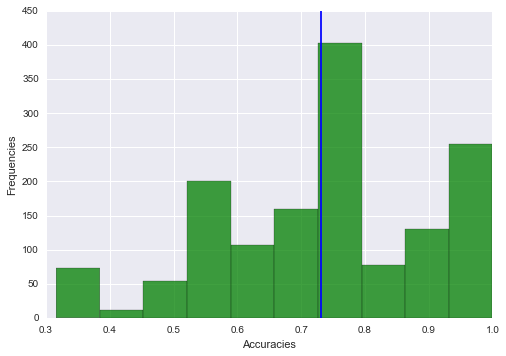

In [9]:
# Parameters for tuning
C = np.power(10., range(-7, 8))

# To keep track of the best model
best_score = 0

# Run grid search for model with 5-fold cross validation
print '5-fold cross validation:'


for c in C:
    # Cross validation for every experiment
    k_folds = KFold(x_train.shape[0], n_folds=5, shuffle=True)
    scores = []
    for train_indices, validation_indices in k_folds:
        # Generate training data
        x_train_cv = x_train.values[train_indices]
        y_train_cv = y_train[train_indices]
        # Generate validation data
        x_validate = x_train.values[validation_indices]
        y_validate = y_train[validation_indices]
        
        # Fit random forest on training data
        model = OneVsRestClassifier(LogisticRegression(C = c))
        model.fit(x_train_cv, y_train_cv)
        # Score on validation data
        scores += [model.score(x_validate, y_validate)]
    # Record and report accuracy
    average_score = np.mean(scores)
    print "c:", c, "Score:", average_score
    
    # Update our record of the best parameters see so far
    if average_score > best_score:
        best_score = average_score
        best_c = c

# Fit model on entire train set using chosen C
ovr_logistic = OneVsRestClassifier(LogisticRegression(C = best_c))
ovr_logistic.fit(x_train, y_train)
ovr_logistic_score = ovr_logistic.score(x_test, y_test)
ovr_logistic_predicted = ovr_logistic.predict(x_test)
ovr_logistic_match = compute_match_ratio(y_test, ovr_logistic_predicted)

In [10]:
print 'Chosen c:', best_c
print 'Test accuracy:', ovr_logistic_score
print 'Match ratio: ', ovr_logistic_match

Chosen c: 10.0
Test accuracy: 0.0169952413324
Match ratio:  (0.73033024437368055, 0.73684210526315785)
